In [1]:
import os

import numpy as np
import pandas as pd
import re

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import notebook


In [2]:
log_file = 'fit_job-45669518.log'
with open(log_file, 'r') as log:
    lines = [line.strip('\n') for line in log.readlines() if line.startswith('Epoch') or line.startswith('1605')]

In [3]:
log_df = pd.DataFrame(columns=['Epoch', 'mean_squared_error_loss', 'root_mean_squared_error', 'mean_absolute_error',
                              'val_mean_squared_error_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])
counter = 1
for line_idx in range(1, len(lines), 2):
    nums = re.findall(r'\d+\.\d+', lines[line_idx])
    log_df.loc[counter - 1, :] = [counter, ] + nums
    counter += 1

for col in log_df.columns:
    log_df[col] = log_df[col].astype('float64')

In [4]:
log_df.head()

,Epoch,mean_squared_error_loss,root_mean_squared_error,mean_absolute_error,val_mean_squared_error_loss,val_root_mean_squared_error,val_mean_absolute_error
0,1.0,286.4797,16.9257,3.1548,9.3915,3.0646,2.5489
1,2.0,9.3604,3.0595,2.5382,9.1508,3.0250,2.5056
2,3.0,8.9558,2.9926,2.4697,8.6168,2.9354,2.4107
3,4.0,8.5981,2.9322,2.4078,8.4189,2.9015,2.3714
4,5.0,8.3824,2.8952,2.3678,8.3979,2.8979,2.3633


Text(0, 0.5, 'Mean Squared Error Loss')

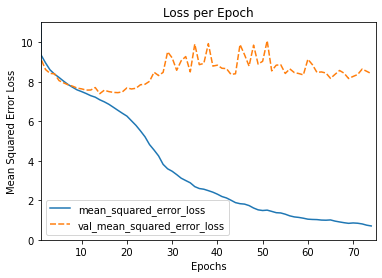

In [5]:
ax = sns.lineplot(data=log_df.loc[:, ['mean_squared_error_loss', 'val_mean_squared_error_loss']])
ax.set_ylim(0, 11)
ax.set_xlim(1, 75)
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')

Text(0.5, 0, 'Epochs')

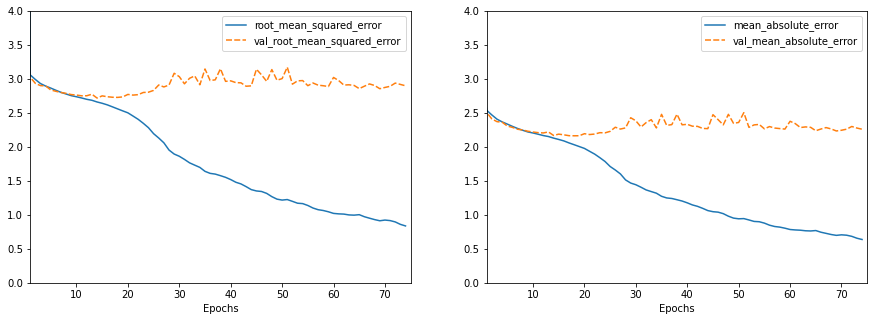

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=log_df.loc[:, ['root_mean_squared_error', 'val_root_mean_squared_error']], ax=ax[0])
ax[0].set_xlim(1, 75)
ax[0].set_ylim(0, 4)
ax[0].set_xlabel('Epochs')
sns.lineplot(data=log_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']], ax=ax[1])
ax[1].set_xlim(1, 75)
ax[1].set_ylim(0, 4)
ax[1].set_xlabel('Epochs')

In [7]:
image_folder_path = 'nn_images/cnn_images'

test_dataframe = pd.read_json('cnn_data_test.json.gz')

In [8]:
test_dataframe = test_dataframe[['vid_id', 'thumb_name', 'vid_viewcount']]
test_dataframe['vid_viewcount'] = np.log(test_dataframe['vid_viewcount'] + 1)
test_dataframe.rename({'vid_viewcount': 'log_vid_viewcount'}, axis=1, inplace=True)

In [9]:
test_dataframe.head()

,vid_id,thumb_name,log_vid_viewcount
0,s7hUDrkbg_E,s7hUDrkbg_E.jpg,8.458504
1,jsoze58Ct7Y,jsoze58Ct7Y.jpg,10.052166
2,IeGS-GzUtOo,IeGS-GzUtOo.jpg,3.044522
3,KqgFCfoH0oI,KqgFCfoH0oI.jpg,4.369448
4,Zv5XJnwi3k0,Zv5XJnwi3k0.jpg,12.254444


In [10]:
# load trained model from best checkpoint
CnnModel = tf.keras.models.load_model('19-2.163541')
CnnModel.summary()

2022-12-10 00:14:18.042418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 00:14:18.557361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14635 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Model: "vgg_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                 

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
def image_prep(image_path, image_size:tuple):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img /= 255
    return img

def load_data(dataframe:pd.DataFrame, images_path:str, image_size:tuple=(224, 224), shuffle:bool=True):
    dataframe_ = dataframe.copy()
    if shuffle:
        dataframe_ = dataframe_.sample(frac=1)

    for_preds = pd.Series(index=dataframe_['vid_id'].values, name='cnn_thumb_preds', dtype='float64')

    dataframe_['thumb_name'] = dataframe_['thumb_name'].apply(lambda name: os.path.join(images_path, name))

    test_data = tf.data.Dataset.from_tensor_slices((dataframe_['thumb_name'].values, dataframe_['vid_id'].values))

    test_data = test_data.map(lambda x, y: (image_prep(x, image_size=image_size), y), num_parallel_calls=AUTOTUNE)

    test_data = test_data.batch(1).prefetch(buffer_size=AUTOTUNE)

    return test_data, for_preds


In [12]:
test_data_for_cnn, for_preds = load_data(test_dataframe, image_folder_path)

In [13]:
for data_batch in notebook.tqdm(test_data_for_cnn):
    image, vid_id = data_batch

    preds = CnnModel.predict(image)
    
    for_preds[vid_id.numpy()[0].decode('utf8')] = preds[0][0]

  0%|          | 0/42802 [00:00<?, ?it/s]

2022-12-10 00:14:21.769840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8401


In [14]:
test_dataframe = test_dataframe.merge(for_preds, left_on='vid_id', right_index=True)

In [15]:
test_dataframe

,vid_id,thumb_name,log_vid_viewcount,cnn_thumb_preds
0,s7hUDrkbg_E,s7hUDrkbg_E.jpg,8.458504,8.505220
1,jsoze58Ct7Y,jsoze58Ct7Y.jpg,10.052166,7.570218
2,IeGS-GzUtOo,IeGS-GzUtOo.jpg,3.044522,11.014213
3,KqgFCfoH0oI,KqgFCfoH0oI.jpg,4.369448,9.921457
4,Zv5XJnwi3k0,Zv5XJnwi3k0.jpg,12.254444,11.544274
...,...,...,...,...
42797,t6tTTgvxMW8,t6tTTgvxMW8.jpg,3.970292,7.534862
42798,CyJ2YgKbFfE,CyJ2YgKbFfE.jpg,8.734399,10.036426
42799,HxFcjfkjpPo,HxFcjfkjpPo.jpg,12.083724,9.814285
42800,B1JuEx3yypQ,B1JuEx3yypQ.jpg,12.394492,8.285105


In [16]:
rmse = mean_squared_error(test_dataframe['log_vid_viewcount'], test_dataframe['cnn_thumb_preds'], squared=False)
mae = mean_absolute_error(test_dataframe['log_vid_viewcount'], test_dataframe['cnn_thumb_preds'])
r2 = r2_score(test_dataframe['log_vid_viewcount'], test_dataframe['cnn_thumb_preds'])

In [17]:
print(f'Root mean squared error: {rmse:.6f}')
print(f'Mean absolute error    : {mae:.6f}')
print(f'r2 score               : {r2:.6f}')

Root mean squared error: 2.740465
Mean absolute error    : 2.173752
r2 score               : 0.243857


Text(0, 0.5, 'Residuals')

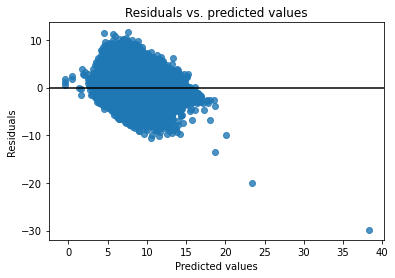

In [18]:
resids = test_dataframe['log_vid_viewcount'] - test_dataframe['cnn_thumb_preds']
ax = sns.regplot(x=test_dataframe['cnn_thumb_preds'], y=resids, fit_reg=False)
ax.axhline(0, color='k')
ax.set_title('Residuals vs. predicted values')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')

In [19]:
test_dataframe.to_json('cnn_test_results.json.gz')